In [1]:
import os
import sys
sys.path.append("..")
import numpy as np
from py_helpers.general_helpers import *

# Define the paths to the results
labs = True
if labs:
    results_path = "/media/hsa22/Expansion/WBM/results"
else:
    results_path = "D:\\WBM\\results"

## **Load the Data**

In [2]:
# Function to return a dictionary of the files organized
def organize_files(txt_files, csv_files, name="model"):

    # Dictionary to store the files
    organized_files = {}

    # Loop through the files and add them to the dictionary
    for file in txt_files:
        # Depending on name, add it to the dictionary
        if name in file:
            # Get whether it's symmetric or not
            symmetric = file.split(os.sep)[-3]
            # Define the corresponding csv as the path up until -1
            corresponding_csv = os.path.join((os.sep).join(file.split(os.sep)[:-1]), "sim_FC.csv")
            # If the csv exists, add it to the dictionary
            if corresponding_csv in csv_files:
                data_dict = {
                    "txt_path": file,
                    "csv_path": corresponding_csv,
                    "correlation": np.loadtxt(file),
                    "sim_FC": np.genfromtxt(corresponding_csv, delimiter=",")
                }
                
                # Append the data dictionary to the organized_files under symmetric key
                if symmetric in organized_files:
                    organized_files[symmetric].append(data_dict)
                else:
                    organized_files[symmetric] = [data_dict]

    # Return the dictionary
    return organized_files

In [3]:
# Grab all the txt and csv files for the correlation
txt_files = glob_files(results_path, "txt")
csv_files = glob_files(results_path, "csv")

# Assert that the number of txt and csv files are the same
assert len(txt_files) == len(csv_files), "Number of txt and csv files are not the same!"

# Get the wilson and kuramoto files individually
wilson_txt_files = [file for file in txt_files if "wilson" in file]
kuramoto_txt_files = [file for file in txt_files if "kuramoto" in file]
wilson_csv_files = [file for file in csv_files if "wilson" in file]
kuramoto_csv_files = [file for file in csv_files if "kuramoto" in file]

# Define dictionary for model, traditional, and tracer files
model_files = organize_files(kuramoto_txt_files, kuramoto_csv_files, name="model")
trad_files = organize_files(kuramoto_txt_files, kuramoto_csv_files, name="traditional")
tracer_files = organize_files(kuramoto_txt_files, kuramoto_csv_files, name="tracer")

# Print the length of each dictionary - or the number of items for both symmetric and asymmetric
# print("Number of symmetric model files: {}".format(len(model_files["symmetric"])))
print("Number of asymmetric model files: {}".format(len(model_files["asymmetric"])))
# print("Number of symmetric traditional files: {}".format(len(trad_files["symmetric"])))
print("Number of asymmetric traditional files: {}".format(len(trad_files["asymmetric"])))
print("Number of symmetric tracer files: {}".format(len(tracer_files["symmetric"])))
print("Number of asymmetric tracer files: {}".format(len(tracer_files["asymmetric"])))

## **Organize Data into Pandas Dataframe**

In [ ]:
import pandas as pd
import re

# Function to organize data into pandas dataframe
def extract_data_and_create_df(entries):
    """Utility function to extract data and create a dataframe."""
    df_rows = []
    for entry in entries:
        # Extract the coupling and delay values using regex
        match = re.search(r"Coupling (\d+\.\d+), Delay(\d+\.\d+)", entry["txt_path"])

        if match:
            coupling, delay = float(match.group(1)), float(match.group(2))
            df_rows.append((coupling, delay, np.float64(entry["correlation"])))

    return pd.DataFrame(df_rows, columns=["Coupling", "Delay", "Correlation"])

In [ ]:
import pandas as pd
import re

# Create a dataframe for the model, traditional, and tracer
model_asym_df = extract_data_and_create_df(model_files["asymmetric"])
trad_asym_df = extract_data_and_create_df(trad_files["asymmetric"])
tracer_asym_df = extract_data_and_create_df(tracer_files["asymmetric"])

# Print the length of each dataframe
print("Number of asymmetric model dataframes: {}".format(len(model_asym_df)))
print("Number of asymmetric traditional dataframes: {}".format(len(trad_asym_df)))
print("Number of asymmetric tracer dataframes: {}".format(len(tracer_asym_df)))

# Print the maximum correlation for each dataframe
print("Max correlation for model: {}".format(model_asym_df["Correlation"].max()))
print("Max correlation for traditional: {}".format(trad_asym_df["Correlation"].max()))
print("Max correlation for tracer: {}".format(tracer_asym_df["Correlation"].max()))

Number of asymmetric model dataframes: 220
Number of asymmetric traditional dataframes: 219
Number of asymmetric tracer dataframes: 303
Max correlation for model: 0.31319284
Max correlation for traditional: 0.04304028
Max correlation for tracer: 0.30285191


In [ ]:
# Print the head of each dataframe
print("Model dataframe head: \n{}".format(model_asym_df.head()))

Model dataframe head: 
   Coupling    Delay  Correlation
0    0.5881  17.9543     0.158697
1    0.6628   3.7955    -0.060397
2    0.4637  13.6279     0.184187
3    0.4637  13.6280     0.184186
4    0.4822  14.2719     0.164985


## **Plot the Data**

In [ ]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def gradient_stem(ax, x, y, z, bottom, color_start, color_end):
    """
    Create a stem plot with gradient color effect.
    :param ax: Axis to plot on
    :param x, y, z: Data for stems
    :param bottom: Bottom of stems
    :param colors: List of color for gradient
    """
    segments = len(z)
    for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
        z_points = np.linspace(bottom, zi, segments)
        colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]
        for j in range(1, segments):
            ax.plot([xi, xi], [yi, yi], [z_points[j-1], z_points[j]], color=colors[j])
            
        # Here we add the circle top at the end of each stem
        ax.scatter(xi, yi, zi, c=[tuple(color_end)], s=20)  # You can adjust `s` for size

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap

%matplotlib widget

def plot_bayesOpt_results(df, title, xlabel, ylabel, zlabel):
    # Extracting data from dataframe
    coupling = df['Coupling'].values
    delay = df['Delay'].values
    correlation = df['Correlation'].values

    # Generate a custom color palette
    color_palette = sns.cubehelix_palette(8, start=0.8, rot=-0.4, dark=0.1, light=0.9)
    beige_palette = sns.light_palette(color_palette[4], n_colors=10)
    
    # Extract specific colors
    pinkish = color_palette[5]
    purpleish = color_palette[7]
    beige_color = beige_palette[1]

    # Extract old stem plot colors
    pinkish_stem = color_palette[2]
    purpleish_stem = color_palette[6]

    # Create a custom colormap using these colors
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom", 
        [beige_color, pinkish, purpleish]
    )

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)
    
    ax1 = ax[0]
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    gradient_stem(ax1, coupling, delay, correlation, correlation.min(), pinkish_stem, purpleish_stem)
    ax1.view_init(elev=10, azim=-110)
    
    # Set labels for ax1
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_zlabel(zlabel, labelpad=7)

    # Add a title
    ax1.set_title("Correlation vs. (Coupling, Delay)", fontsize=15)

    # Calculate KDE for ax2
    values = np.vstack([df['Coupling'], df['Delay']])
    kernel = gaussian_kde(values)

    x, y = np.mgrid[df['Coupling'].min():df['Coupling'].max():100j, df['Delay'].min():df['Delay'].max():100j]
    positions = np.vstack([x.ravel(), y.ravel()])
    z = np.reshape(kernel(positions).T, x.shape)
    
    ax2 = ax[1]
    # Filled contour
    c = ax2.contourf(x, y, z, levels=12, cmap=custom_cmap)

    # Contour lines with labels
    cs = ax2.contour(x, y, z, levels=12, colors='black')
    ax2.clabel(cs, inline=True, fontsize=10, fmt='%1.2f')
    
    fig.colorbar(c, ax=ax2, shrink=0.5, aspect=5)

    # To zoom in/out adjust the box dimensions (you can modify these values for the desired zoom level)
    ax1.auto_scale_xyz([df['Coupling'].min(), df['Coupling'].max()], 
                    [df['Delay'].min(), df['Delay'].max()], 
                    [correlation.min(), correlation.max()])
    
    # Remove outer ticks from ax1
    ax1.tick_params(axis='x', direction='in')
    ax1.tick_params(axis='y', direction='in')
    ax1.tick_params(axis='z', direction='in')

    # Set labels for ax
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)

    # Add a title
    ax2.set_title("Density Estimation of (Coupling, Delay) Choices", fontsize=15)

    # Set the title
    fig.suptitle("{title} - Optimization Results".format(title=title), fontsize=20)

    plt.show()

/tmp/ipykernel_176414/3740401266.py:28: RuntimeWarning: invalid value encountered in scalar divide
  colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]


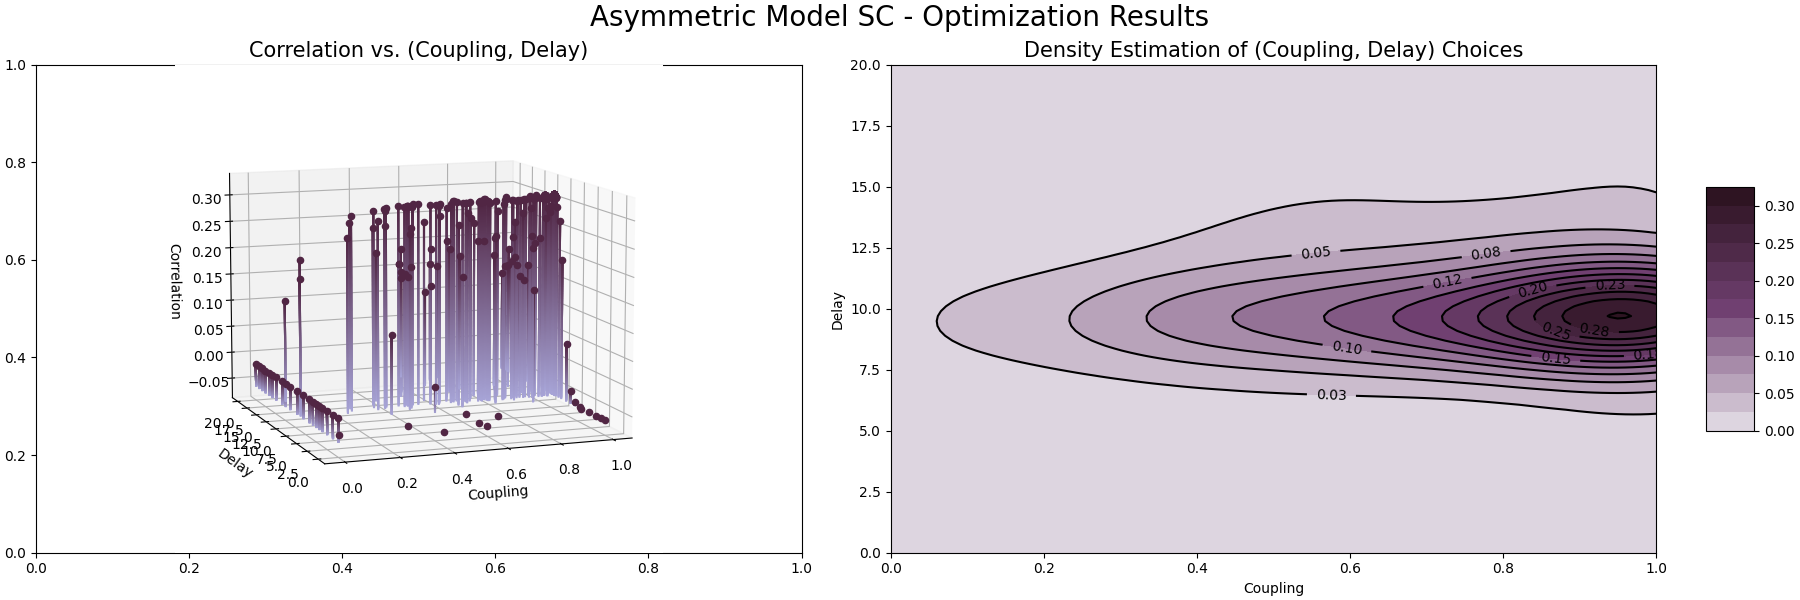

In [ ]:
%matplotlib widget

plot_bayesOpt_results(model_asym_df, "Asymmetric Model SC", "Coupling", "Delay", "Correlation")

/tmp/ipykernel_176414/3057472873.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)
/tmp/ipykernel_176414/3740401266.py:28: RuntimeWarning: invalid value encountered in scalar divide
  colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]


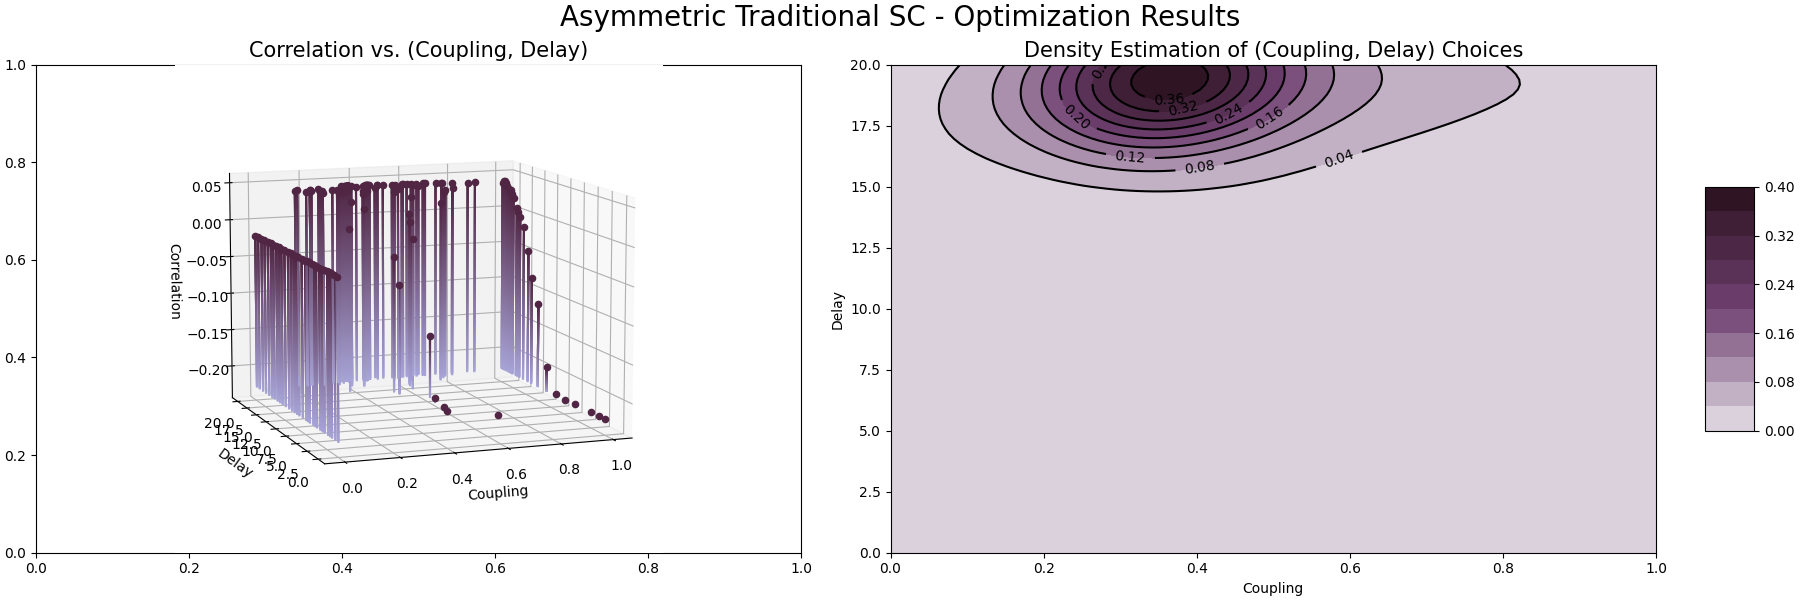

In [40]:
%matplotlib widget

plot_bayesOpt_results(trad_asym_df, "Asymmetric Traditional SC", "Coupling", "Delay", "Correlation")

In [41]:
%matplotlib widget

plot_bayesOpt_results(tracer_asym_df, "Asymmetric Tracer SC", "Coupling", "Delay", "Correlation")

/tmp/ipykernel_176414/3740401266.py:28: RuntimeWarning: invalid value encountered in scalar divide
  colors = [((zi - v) / (zi - bottom) * np.array(color_start) + (v - bottom) / (zi - bottom) * np.array(color_end)) for v in z_points]


: 

: 